In [76]:
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer #, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, MaxAbsScaler

from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc, SCORERS
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn import set_config
set_config(display ="diagram")

import matplotlib.pyplot as plt
%matplotlib inline

In [77]:

full_df=pd.read_csv('../data/processed/crashes.gz', compression='gzip', low_memory=False)



In [78]:
selected_df=full_df.dropna(subset=['SAFETY_EQUIPMENT'], axis=0)
selected_df=selected_df[full_df['SAFETY_EQUIPMENT'] != 'UNKNOWN']

selected_df=full_df[['GUILTY','DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 
           'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','VEHICLE_DEFECT', 'ROAD_DEFECT',
             'DRIVERS_LICENSE_CLASS', 'AGE_GROUP', 'VEHICLE_AGE', 'AIRBAG_DEPLOYED',
            'PHYSICAL_CONDITION', 'MANEUVER',  'DRIVER_VISION',  'ALIGNMENT' ,  'TRAFFIC_CONTROL_DEVICE',
                    'NUM_PASSENGERS','SUN_GLARE','VEHICLE_YEAR','AGE','SAFETY_EQUIPMENT',
                     'VEHICLE_TYPE']].copy()

#SAFETY_EQUIPMENT

#explore_cat_vars(full_df, 42)

#selected_df['CRASH_TYPE'] = np.where(selected_df['CRASH_TYPE'] == 'NO INJURY / DRIVE AWAY', 0, 1).copy()


In [92]:
sample_df=selected_df.sample(10000, random_state=100)
#sample_df=selected_df.copy()

y = sample_df['GUILTY']
x = sample_df.drop(['GUILTY'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=43, test_size=0.25, stratify=y)

X_train=X_train.apply(LabelEncoder().fit_transform)
X_test=X_test.apply(LabelEncoder().fit_transform)

In [93]:
#numeric_columns = []

#nominal_columns = [ 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 'MANEUVER' ] 


# 'AIRBAG_DEPLOYED',  'PHYSICAL_CONDITION', 'AGE_GROUP', 'VEHICLE_AGE', 'DRIVERS_LICENSE_CLASS', 
#, 'TRAFFICWAY_TYPE', ,'SUN_GLARE' , 'AGE',
#'ALIGNMENT' ,  'DEVICE_CONDITION','DRIVER_VISION',
#'NUM_PASSENGERS' , 
# 'SAFETY_EQUIPMENT',  'ROAD_DEFECT', 'ROADWAY_SURFACE_COND', 
#'TRAFFIC_CONTROL_DEVICE', 
###'VEHICLE_DEFECT', 

##,  'AIRBAG_DEPLOYED'

#X_train = X_train[numeric_columns+nominal_columns]
#X_test = X_test[numeric_columns+nominal_columns]

#X_train.info()

In [104]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numeric_columns)),
#        ('imputer', SimpleImputer(strategy = 'constant', fill_value=0))
        ('std_scaler', StandardScaler())
 #        ( 'polynomial', PolynomialFeatures(degree = 3, include_bias = False ))
        
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(nominal_columns)),
#        ('imputer', SimpleImputer(strategy = 'most_frequent')),
#        ('cat_encoder', OneHotEncoder(sparse=False, handle_unknown =  'ignore' )),
    ])


fu = FeatureUnion(transformer_list=[
#        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])




In [105]:
XGB_pipeline = Pipeline([ ( 'fu', fu ),
                  ('boost', XGBClassifier(use_label_encoder=False, 
                                          eval_metric='auc', gamma= 0.02, max_depth=3, n_estimators=90, n_jobs=-1))
                 ])



In [106]:
pipe_grid={'boost__gamma':[0.01,0.015]}
#pipe_grid={'boost__gamma':[0.01,0.015], 'boost__n_estimators':[110,130,150]}

gs_pipe = GridSearchCV(estimator=XGB_pipeline, param_grid=pipe_grid,  cv=3, scoring='roc_auc')

#pd.DataFrame(SCORERS.keys())

In [107]:
gs_pipe.fit(X_train, y_train)
#XGB_pipeline.fit(X_train, y_train)




        


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('fu',
                                        FeatureUnion(transformer_list=[('cat_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['FIRST_CRASH_TYPE',
                                                                                                                            'FIRST_CONTACT_POINT',
                                                                                                                            'MANEUVER',
                                                                                                                            'TRAFFIC_CONTROL_DEVICE',
                                                                                                                            'PHYSICAL_CONDITION',
                                                                                                                            'VEHICLE_DEFECT']))]))])),
                                       ('boost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_byle...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=90,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                                      subsample=None,
                                                      tree_method=None,
                                                      use_label_encoder=False,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             param_grid={'boost__gamma': [0.01, 0.015]}, scoring='roc_auc')

In [152]:
gs_pipe

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('fu',
                                        FeatureUnion(transformer_list=[('cat_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['FIRST_CRASH_TYPE',
                                                                                                                            'FIRST_CONTACT_POINT',
                                                                                                                            'MANEUVER',
                                                                                                                            'TRAFFIC_CONTROL_DEVICE',
                                                                                                                            'PHYSICAL_CONDITION',
                                                                                                                            'VEHICLE_DEFECT']))]))])),
                                       ('boost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_byle...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=90,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                                      subsample=None,
                                                      tree_method=None,
                                                      use_label_encoder=False,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             param_grid={'boost__gamma': [0.01, 0.015]}, scoring='roc_auc')

In [108]:
#y_pred_train=gs_pipe.predict(X_train)
y_pred_test=gs_pipe.predict(X_test)

#y_pred_train=XGB_pipeline.predict(X_train)
#y_pred_test=XGB_pipeline.predict(X_test)

Index(['VEHICLE_DEFECT', 'PHYSICAL_CONDITION', 'TRAFFIC_CONTROL_DEVICE',
       'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 'MANEUVER'],
      dtype='object')

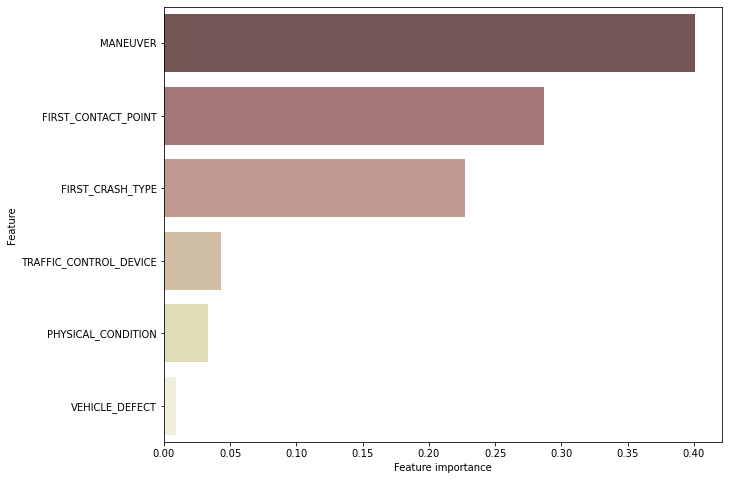

In [304]:

cols=gs_pipe.best_estimator_[0].transformer_list[0][1][0].get_params()['attribute_names']
#gs_pipe.best_params_
import seaborn as sns

def plot_feature_importances(model, cols):
    n_features = len(cols)
    fig, ax = plt.subplots(figsize=(10,8))
    list_of_lists=[np.arange(n_features),list(model.feature_importances_)]
    
    df=pd.DataFrame(list_of_lists, columns=cols).T.sort_values(by=1, ascending=False)
    
    sns.barplot(x=1,y=0,data=df, order=df.sort_values(1,ascending=False)[0], ax=ax, orient='h', palette='pink')
    plt.yticks(np.arange(n_features), df.sort_values(1, ascending=False)[0].index)
    ax.set_xlabel('Feature importance')
    ax.set_ylabel('Feature')

plot_feature_importances(gs_pipe.best_estimator_[1], cols)


df=pd.DataFrame(list_of_lists, columns=cols).T.sort_values(by=1, ascending=False)
df.sort_values(1)[0].index

In [306]:
#print(XGB_pipeline.score(X_train, y_train ))
print(gs_pipe.score(X_train, y_train ))
#print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))

0.8592988530123999
------------
              precision    recall  f1-score   support

           0       0.90      0.59      0.71      1637
           1       0.53      0.88      0.66       863

    accuracy                           0.69      2500
   macro avg       0.72      0.74      0.69      2500
weighted avg       0.78      0.69      0.70      2500



In [ ]:
def explore_cat_vars(df, n):
    col_counts=pd.DataFrame(df.nunique(),).reset_index()
    col_counts.columns=(["Col_Name", "Count"])
    for col in col_counts[col_counts['Count'] < n]['Col_Name']:
        print('--------------------------------------')
        print(col)
        print('--------------------------------------')
        print(df[col].value_counts())
    print("=================================================================================================")
    print(col_counts[col_counts['Count'] >= n])

In [45]:

nominal_cols=['AIRBAG_DEPLOYED',  'PHYSICAL_CONDITION', 'AGE_GROUP', 'VEHICLE_AGE', 
      'DRIVERS_LICENSE_CLASS','TRAFFICWAY_TYPE', 'SUN_GLARE' , 'ALIGNMENT' ,  
      'DEVICE_CONDITION','DRIVER_VISION', 'SAFETY_EQUIPMENT',  
      'ROAD_DEFECT', 'ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'VEHICLE_DEFECT']


model_dic={}
print('Working with basic 3 cols')

nominal_columns=[ 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 'MANEUVER', 'XGB_TRAFFIC_CONTROL_DEVICE', 'XGB_PHYSICAL_CONDITION']
X_sel_train = X_train [nominal_columns] 
X_sel_test = X_test [nominal_columns]

gs_pipe.fit(X_sel_train, y_train)
y_pred_test=gs_pipe.predict(X_sel_test)
dic_key='XGB_base'
model_dic[dic_key]=gs_pipe
base_models_df = pd.DataFrame(columns=pd.DataFrame(model_dic['XGB_base'].cv_results_).columns)

model_df=pd.DataFrame(model_dic[dic_key].cv_results_)
model_df["Extra Columns"]=dic_key
base_models_df=pd.concat([model_df, base_models_df], axis=0 )


Working with basic 3 cols


In [63]:

model_dic={}

nominal_cols=['AIRBAG_DEPLOYED',  'PHYSICAL_CONDITION', 'AGE_GROUP', 'VEHICLE_AGE', 
      'DRIVERS_LICENSE_CLASS','TRAFFICWAY_TYPE', 'SUN_GLARE' , 'ALIGNMENT' ,  
      'DEVICE_CONDITION','DRIVER_VISION', 'SAFETY_EQUIPMENT',  
      'ROAD_DEFECT', 'ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'VEHICLE_DEFECT']


model_dic={}
print('Working with basic 3 cols')

nominal_columns=[ 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 'MANEUVER','TRAFFIC_CONTROL_DEVICE', 'PHYSICAL_CONDITION']
X_sel_train = X_train [nominal_columns] 
X_sel_test = X_test [nominal_columns]

gs_pipe.fit(X_sel_train, y_train)
y_pred_test=gs_pipe.predict(X_sel_test)
dic_key='XGB_base'
model_dic[dic_key]=gs_pipe
all_models_df = pd.DataFrame(columns=pd.DataFrame(model_dic['XGB_base'].cv_results_).columns)

model_df=pd.DataFrame(model_dic[dic_key].cv_results_)
model_df["Extra Columns"]=dic_key
all_models_df=pd.concat([model_df, all_models_df], axis=0 )


for col in nominal_cols : 
    nominal_columns=[ 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 'MANEUVER', 'TRAFFIC_CONTROL_DEVICE', 'PHYSICAL_CONDITION', col ]
    X_sel_train = X_train [nominal_columns] 
    X_sel_test = X_test [nominal_columns]
    print('---------------------')
    print ("Working with", col)

    cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(nominal_columns)),
        ('cat_encoder', OneHotEncoder(sparse=False, handle_unknown =  'ignore' )),
    ])


    fu = FeatureUnion(transformer_list=[
        ("cat_pipeline", cat_pipeline),
    ])


    XGB_pipeline = Pipeline([ ( 'fu', fu ),
                  ('boost', XGBClassifier(use_label_encoder=False, 
                                          eval_metric='auc', gamma= 0.02, max_depth=3, n_estimators=90, n_jobs=-1))
                 ])

    pipe_grid={'boost__gamma':[0.01,0.015]}

    gs_pipe = GridSearchCV(estimator=XGB_pipeline, param_grid=pipe_grid,  cv=3, scoring='roc_auc')
    
#    model_dic={}

    gs_pipe.fit(X_sel_train, y_train)
    y_pred_test=gs_pipe.predict(X_sel_test)
    
    dic_key=f'XGB_{col}'
    model_dic[dic_key]=gs_pipe
   
    model_df=pd.DataFrame(gs_pipe.cv_results_)
    model_df["Extra Columns"]=dic_key
    all_models_df=pd.concat([model_df, all_models_df], axis=0 )





Working with basic 3 cols
---------------------
Working with AIRBAG_DEPLOYED
---------------------
Working with PHYSICAL_CONDITION
---------------------
Working with AGE_GROUP
---------------------
Working with VEHICLE_AGE
---------------------
Working with DRIVERS_LICENSE_CLASS
---------------------
Working with TRAFFICWAY_TYPE
---------------------
Working with SUN_GLARE
---------------------
Working with ALIGNMENT
---------------------
Working with DEVICE_CONDITION
---------------------
Working with DRIVER_VISION
---------------------
Working with SAFETY_EQUIPMENT
---------------------
Working with ROAD_DEFECT
---------------------
Working with ROADWAY_SURFACE_COND
---------------------
Working with TRAFFIC_CONTROL_DEVICE
---------------------
Working with VEHICLE_DEFECT


In [64]:

all_models_df.sort_values(by='mean_test_score', ascending=False) 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boost__gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,Extra Columns
0,8.369722,0.092049,0.306258,0.048797,0.01,{'boost__gamma': 0.01},0.855710,0.851336,0.853476,0.853508,0.001786,1,XGB_DRIVER_VISION
1,8.368030,0.077146,0.258861,0.021007,0.015,{'boost__gamma': 0.015},0.855710,0.851335,0.853476,0.853507,0.001786,2,XGB_DRIVER_VISION
1,7.879195,0.070918,0.264572,0.007693,0.015,{'boost__gamma': 0.015},0.855365,0.851369,0.853276,0.853337,0.001632,1,XGB_SAFETY_EQUIPMENT
0,7.769477,0.127879,0.264876,0.034131,0.01,{'boost__gamma': 0.01},0.855365,0.851369,0.853276,0.853337,0.001632,1,XGB_SAFETY_EQUIPMENT
1,7.892563,0.125687,0.258545,0.016329,0.015,{'boost__gamma': 0.015},0.855040,0.851513,0.853178,0.853244,0.001441,1,XGB_AGE_GROUP
0,7.798790,0.062446,0.264116,0.024896,0.01,{'boost__gamma': 0.01},0.855040,0.851513,0.853178,0.853244,0.001441,1,XGB_AGE_GROUP
0,9.098115,0.359362,0.297098,0.014854,0.01,{'boost__gamma': 0.01},0.855208,0.851533,0.852804,0.853182,0.001524,1,XGB_TRAFFICWAY_TYPE
1,9.041896,0.211232,0.245806,0.015458,0.015,{'boost__gamma': 0.015},0.855208,0.851440,0.852804,0.853151,0.001558,2,XGB_TRAFFICWAY_TYPE
0,7.890303,0.243577,0.329286,0.065036,0.01,{'boost__gamma': 0.01},0.854989,0.851287,0.852549,0.852942,0.001537,1,XGB_AIRBAG_DEPLOYED
1,8.278707,0.671307,0.252624,0.016316,0.015,{'boost__gamma': 0.015},0.854914,0.851287,0.852549,0.852917,0.001504,2,XGB_AIRBAG_DEPLOYED


In [75]:
import pickle
import sklearn


pkl_file_name='XGB_models.pikle'


with open (pkl_file_name, 'wb') as file:
    pickle.dump(model_dic, file)
    
    